# Part 2 - Data analysis
*[5 points]*

Uber’s Driver team is interested in predicting which driver signups are most likely to
start driving. To help explore this question, we have provided a
**sample1 dataset of a cohort of driver signups in January 2015**.
The data was pulled a few months after they signed up to include the
result of whether they actually completed their first trip.
It also includes several pieces of background information gather about the driver and their car.

We would like you to use this data set to help understand what factors are best at predicting whether
a signup will start to drive, and offer suggestions to operationalize those insights to help Uber.

See below for a detailed description of the dataset. Please include any code you wrote for the analysis
and delete the dataset when you have finished with the challenge. Please also call out any data related
assumptions or issues that you encounter.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis
(a few sentences/plots describing your approach will suffice). **What fraction of the driver signups took a first trip?** (2 points)

2. **Build a predictive model to help Uber determine whether or not a driver signup will start driving**.
Discuss why you chose your approach, what alternatives you considered, and any concerns you have.
How valid is your model? Include any key indicators of model performance. (2 points)

3. Briefly discuss **how Uber might leverage the insights gained from the model to generate more first trips**
(again, a few ideas/sentences will suffice). (1 point)

```python
Data description:

id: driver_id
city_id: city_id this user signed up in
signup_os: signup device of the user (“android”, “ios”, “website”, “other”)
signup_channel: what channel did the driver sign up from (“offline”, “paid”, “organic”, “referral”)
signup_timestamp: timestamp of account creation; local time in the form ‘YYYY-MM-DD’
bgc_date: date of background check consent; in the form ‘YYYY-MM-DD’
vehicle_added_date: date when driver’s vehicle information was uploaded; in the form ‘YYYY-MM-DD’
first_completed_date: date of the first trip as a driver; in the form ‘YYYY-MM-DD’
vehicle_make: make of vehicle uploaded (i.e. Honda, Ford, Kia)
vehicle_model: model of vehicle uploaded (i.e. Accord, Prius, 350z)
vehicle_year: year that the car was made; in the form ‘YYYY’
```

# 0. Load necessary packages and the data itself

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [42]:
df = pd.read_csv('data/ds_challenge_v2_1_data.csv',
                 index_col=['id'],
                 parse_dates=['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date'])

In [43]:
df.head()

,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
id,,,,,,,,,,
1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT
2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT
3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT
4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03
5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT


# 1. EDA and Data Cleaning
Summary:
- Records with dates that do not follow the rules are removed

In [44]:
# Size of data
print('Size of Data:', df.shape)
print('')

# Null and unique values
summary = pd.DataFrame({'Column Types': df.dtypes,
                        'Number of Nulls': df.isna().sum(),
                        'Unique Values': df.nunique()})
print(summary)

Size of Data: (54681, 10)

                        Column Types  Number of Nulls  Unique Values
city_name                     object                0              3
signup_os                     object             6857              5
signup_channel                object                0              3
signup_date           datetime64[ns]                0             30
bgc_date              datetime64[ns]            21785             74
vehicle_added_date    datetime64[ns]            41547             78
vehicle_make                  object            41458             46
vehicle_model                 object            41458            368
vehicle_year                 float64            41458             24
first_completed_date  datetime64[ns]            48544             57


In [45]:
# Check out the few categorical columns with few categories
# The other two features, vehicle model/make, have too many categories to check for errors for this challenge
cols = ['city_name', 'signup_os', 'signup_channel']
for col in cols:
    print(col)
    print(df[col].value_counts())
    print()

city_name
Strark     29557
Berton     20117
Wrouver     5007
Name: city_name, dtype: int64

signup_os
ios web        16632
android web    14944
windows         6776
mac             5824
other           3648
Name: signup_os, dtype: int64

signup_channel
Paid        23938
Referral    17316
Organic     13427
Name: signup_channel, dtype: int64



In [46]:
# Check out the few date columns
cols = ['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date']
for col in cols:
    print('{}: from {} to {}'.format(col, df[col].min().date(), df[col].max().date()))


signup_date: from 2016-01-01 to 2016-01-30
bgc_date: from 2016-01-01 to 2016-03-25
vehicle_added_date: from 2016-01-01 to 2016-03-26
first_completed_date: from 2016-01-04 to 2016-02-29


In [47]:
# A few sanitary checks on dates
print('Instances where signup_date > bgc_date:', (df['signup_date']>df['bgc_date']).sum())
print('Instances where signup_date > vehicle_added_date:', (df['signup_date']>df['vehicle_added_date']).sum())
print('Instances where signup_date > first_completed_date:', (df['signup_date']>df['first_completed_date']).sum())
print('Instances where vehicle_added_date > first_completed_date:', (df['vehicle_added_date']>df['first_completed_date']).sum())
print('Instances where bgc_date > first_completed_date:', (df['bgc_date']>df['first_completed_date']).sum())

Instances where signup_date > bgc_date: 0
Instances where signup_date > vehicle_added_date: 1
Instances where signup_date > first_completed_date: 0
Instances where vehicle_added_date > first_completed_date: 54
Instances where bgc_date > first_completed_date: 33


In [48]:
# Let remove rows that violate the above rules
df = df[-(df['signup_date']>df['vehicle_added_date'])][
    -(df['vehicle_added_date']>df['first_completed_date'])][
    -(df['bgc_date']>df['first_completed_date'])]

<ipython-input-48-e6aa890b3beb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[-(df['signup_date']>df['vehicle_added_date'])][


1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis
(a few sentences/plots describing your approach will suffice). **What fraction of the driver signups took a first trip?** (2 points)

In [49]:
ratio = df['first_completed_date'].notna().sum()/len(df)
print('{:.2%} of the driver signups took a first trip'.format(ratio))

11.10% of the driver signups took a first trip


2. **Build a predictive model to help Uber determine whether or not a driver signup will start driving**.
Discuss why you chose your approach, what alternatives you considered, and any concerns you have.
How valid is your model? Include any key indicators of model performance. (2 points)

In [50]:
# Prepare training data - Baseline
df['signup_day_of_week'] = df['signup_date'].dt.day_of_week.fillna(-1)
df['days_between_bgc_signup'] = (df['bgc_date'] - df['signup_date']).dt.days.fillna(-1)
df['days_between_add_vehicle_signup'] = (df['vehicle_added_date'] - df['signup_date']).dt.days.fillna(-1)
df['vehicle_year'] = df['vehicle_year'].fillna(-1)
df = df.fillna('Unknown')

cols_x = ['city_name', 'signup_os', 'signup_channel', 'vehicle_year', 'vehicle_model']
cols_x += ['signup_day_of_week', 'days_between_bgc_signup', 'days_between_add_vehicle_signup']

x = pd.get_dummies(df[cols_x])
y = df['first_completed_date'] != 'Unknown'

In [51]:
# Split training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [52]:
model = RandomForestClassifier(n_estimators=100,
                               n_jobs=-1,
                               oob_score=True,
                               class_weight='balanced')
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True)

In [53]:
# This stupid thing is not learning anything!
print('Dummy Test Accuracy: {:.2%}'.format(accuracy_score([0] * len(y_test), y_test)))
print('Training Accuracy: {:.2%}'.format(accuracy_score(model.predict(x_train), y_train)))
print('Training Accuracy(OOB): {:.2%}'.format(accuracy_score(np.argmax(model.oob_decision_function_,axis=1), y_train)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(model.predict(x_test), y_test)))

Dummy Test Accuracy: 88.96%
Training Accuracy: 99.49%
Training Accuracy(OOB): 93.64%
Test Accuracy: 93.36%


In [54]:
model.predict(x_test).mean()

0.12755242193938285

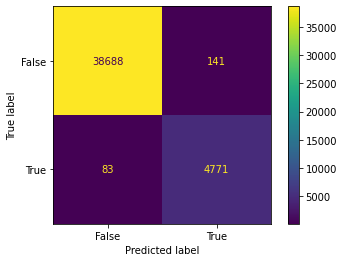

In [55]:
plot_confusion_matrix(model, x_train, y_train)

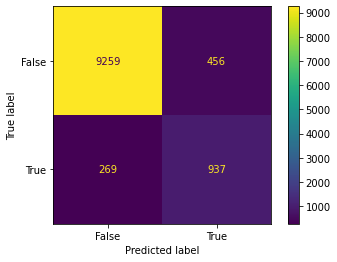

In [56]:
plot_confusion_matrix(model, x_test, y_test)

And RF can deal extremely well with correlated variables. Also, RF works well in high dimensions and requires minimum time to be optimized.

In [57]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=3)
model.fit(x_train, y_train)
# This stupid thing is not learning anything!
print('Dummy Test Accuracy: {:.2%}'.format(accuracy_score([0] * len(y_test), y_test)))
print('Training Accuracy: {:.2%}'.format(accuracy_score(model.predict(x_train), y_train)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(model.predict(x_test), y_test)))

Dummy Test Accuracy: 88.96%
Training Accuracy: 94.08%
Test Accuracy: 93.65%


In [58]:
x

,vehicle_year,signup_day_of_week,days_between_bgc_signup,days_between_add_vehicle_signup,city_name_Berton,city_name_Strark,city_name_Wrouver,signup_os_Unknown,signup_os_android web,signup_os_ios web,...,vehicle_model_ZDX,vehicle_model_Zephyr,vehicle_model_e-Golf,vehicle_model_i3,vehicle_model_iA,vehicle_model_iM,vehicle_model_tC,vehicle_model_xA,vehicle_model_xB,vehicle_model_xD
id,,,,,,,,,,,,,,,,,,,,,
1,-1.0,5,-1.0,-1.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-1.0,3,-1.0,-1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.0,0,0.0,-1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016.0,4,5.0,5.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2016.0,6,15.0,16.0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54677,-1.0,4,-1.0,-1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54678,-1.0,3,-1.0,-1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54679,-1.0,2,-1.0,-1.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [59]:

from dtreeviz.trees import dtreeviz

In [60]:
viz = dtreeviz(model,
               x_test,
               y_test,
               target_name='price',
               feature_names=x.columns)

viz.save_svg()

'/var/folders/68/j99s1lkj7qz5ztbjt3fvh7cw0000gn/T/DTreeViz_32783.svg'

In [95]:
df2 = df
df2['lr_days_between_bgc_signup'] = df2['days_between_bgc_signup'] < 0
df2['lr_days_between_add_vehicle_signup'] = df2['days_between_add_vehicle_signup'] < 0
df2['lr_signup_channel_Referral'] = df2['signup_channel'] == 'Referral'
df2['lr_signup_os_Unknown'] = df2['signup_os'] == 'Unknown'
df2['vehicle_year>2000'] = df2['vehicle_year']>2000
df2['vehicle_year==-1'] = df2['vehicle_year']==-1

In [114]:
x = df2[['lr_days_between_add_vehicle_signup',
         'lr_days_between_bgc_signup',
         'days_between_add_vehicle_signup',
         'vehicle_year>2000',
         'vehicle_year==-1']]
y = df['first_completed_date'] != 'Unknown'
# Split training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [112]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
# This stupid thing is not learning anything!
print('Dummy Test Accuracy: {:.2%}'.format(accuracy_score([0] * len(y_test), y_test)))
print('Training Accuracy: {:.2%}'.format(accuracy_score(model.predict(x_train), y_train)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(model.predict(x_test), y_test)))

Dummy Test Accuracy: 88.96%
Training Accuracy: 94.37%
Test Accuracy: 94.05%


In [104]:
model.predict(x_test).mean()

0.1199523853127003

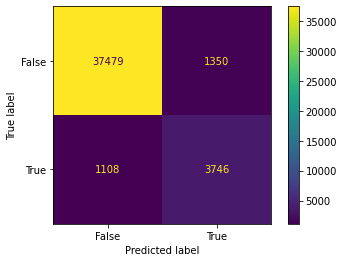

In [105]:
plot_confusion_matrix(model, x_train, y_train)

['city_name',
 'signup_os',
 'signup_channel',
 'signup_date',
 'bgc_date',
 'vehicle_added_date',
 'vehicle_make',
 'vehicle_model',
 'vehicle_year',
 'first_completed_date',
 'signup_day_of_week',
 'days_between_bgc_signup',
 'days_between_add_vehicle_signup',
 'lr_days_between_bgc_signup',
 'lr_days_between_add_vehicle_signup',
 'lr_signup_channel_Referral',
 'lr_signup_os_Unknown']

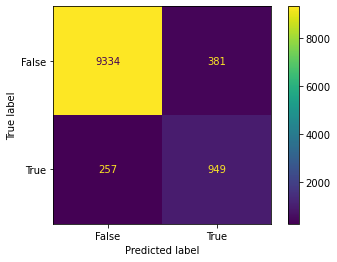

In [80]:
plot_confusion_matrix(model, x_test, y_test)
df2.columns.to_list()

In [113]:
# Narrative between the models
# A comprehensive evaluation function

,lr_days_between_add_vehicle_signup,lr_days_between_bgc_signup,days_between_add_vehicle_signup,vehicle_year>2000,vehicle_year==-1,log
id,,,,,,
1,True,True,-1.0,False,True,1.098612
2,True,True,-1.0,False,True,1.098612
3,True,False,-1.0,False,True,1.098612
4,False,False,5.0,True,False,0.693147
5,False,False,16.0,True,False,0.693147
...,...,...,...,...,...,...
54677,True,True,-1.0,False,True,1.098612
54678,True,True,-1.0,False,True,1.098612
54679,True,True,-1.0,False,True,1.098612
